
<a id='iterative-methods-sparsity'></a>

# Conditioning and Iterative Methods

## Contents

- [Conditioning and Iterative Methods](#Conditioning-and-Iterative-Methods)  
  - [Overview](#Overview)  
  - [Digression on Allocations and Inplace Operations](#Digression-on-Allocations-and-Inplace-Operations)  
  - [Ill-conditioned Matrices](#Ill-conditioned-Matrices)  

## Overview

This lecture takes the structure of :doc:` numerical methods for linear algebra <numerical_linear_algebra>` and builds further
towards working with large, sparse matrices.  In the process, we will examine foundational numerical analysis such as
ill-conditioned matrices.

### Setup

In [1]:
using LinearAlgebra, Statistics, BenchmarkTools, Random
Random.seed!(42);  # seed random numbers for reproducibility

## Digression on Allocations and Inplace Operations

While we have usually not considered optimizing code for performance (and focused on the choice of
algorithms instead), when matrices and vectors become large we need to be more careful.

The most important thing to avoid are excess allocations, which usually occur due to the use of
temporary vectors and matrices when they are not necessary.  However, caution is suggested since
excess allocations are never relevant for scalar values, and can sometimes create faster code for
smaller matrices/vectors.

To see this, a convenient tool is the benchmarking

In [2]:
using BenchmarkTools
A = rand(10,10)
B = rand(10,10)
C = similar(A)
function f!(C, A, B)
    D = A*B
    C .= D .+ 1
end
@btime f!($C, $A, $B)

  703.093 ns (1 allocation: 896 bytes)


10×10 Array{Float64,2}:
 2.05377  3.54295  3.54373  2.67476  …  2.94892  2.85674  4.31835  3.61997
 2.06746  3.84457  3.66934  2.41253     2.59276  2.97454  3.77674  3.85933
 2.69471  3.69253  3.47348  2.42678     3.16387  2.93291  4.30559  4.04421
 1.67775  2.87454  2.71722  2.12581     2.53179  2.53006  3.28715  3.13243
 2.94419  4.25369  4.76694  3.37739     3.37462  3.88731  5.9673   5.15848
 2.17917  3.33133  3.29258  2.4724   …  2.69201  2.37245  4.43653  3.11749
 2.6905   3.57988  4.07824  2.73861     3.12524  3.19379  4.36279  4.44866
 2.3215   3.62217  3.98093  2.62795     2.81179  2.75228  4.04958  3.78597
 3.43598  4.06936  4.63519  3.53287     3.54554  3.68065  5.92299  5.08063
 2.6593   4.53135  3.89724  2.90435     3.78437  3.44159  5.46405  4.62384

The `!` on the `f!` is an informal way to say that the function is mutating, and the first arguments `C`
is by convention the modified values.

There, notice that the `D` is a temporary variable which is created, and then modified afterwards.  However, notice that since
`C` is modified directly, there is no need to create the temporary matrix.

This is an example of where an inplace version of the matrix multiplication can help avoid the allocation.

In [3]:
function f2!(C, A, B)
    mul!(C, A, B)  # in place multiplication
    C .+= 1
end
A = rand(10,10)
B = rand(10,10)
C = similar(A)
@btime f!($C, $A, $B)
@btime f2!($C, $A, $B)

  387.310 ns (1 allocation: 896 bytes)
  339.269 ns (0 allocations: 0 bytes)


10×10 Array{Float64,2}:
 3.97642  3.75592  3.53561  4.14493  …  4.06177  4.14201  4.33629  3.4129 
 4.90616  4.59522  2.90181  4.42233     4.71807  4.4469   4.20378  3.8899 
 4.73405  4.5315   3.13249  4.39273     4.57484  4.41271  4.13719  3.84428
 3.38807  3.506    2.79716  3.38361     3.21753  3.65848  3.476    2.7653 
 5.10006  5.05846  3.27531  4.51467     4.91365  4.9686   4.50291  3.61179
 4.03978  3.79944  3.24381  4.47524  …  4.18798  4.50082  3.94154  3.77894
 4.00862  3.47503  2.55962  3.7897      3.66643  3.33312  3.34651  3.72402
 3.76677  3.64387  2.25138  4.07703     4.07483  3.60404  3.13914  3.55766
 4.18579  4.02072  2.94822  3.8008      4.43307  4.1685   3.56851  3.55096
 4.78127  4.11187  3.47551  4.64188     4.98196  4.83695  4.52626  4.22579

Note in the output of the benchmarking, the `f2!` is non-allocating and is using the preallocated `C` variable directly.

Another example of this is solutions to linear equations.

In [4]:
A = rand(10,10)
y = rand(10)
z = A \ y  # creates temporary

A = factorize(A)  # inplace requires factorization
x = similar(y)
ldiv!(x, A, y)  # inplace left divide, using factorization

10-element Array{Float64,1}:
 -4.147358274782724   
  0.006333895352347378
 -5.7598642764249375  
  3.1536084825273347  
  4.307861133875411   
  0.19331420064792734 
 -0.2035796388307043  
 -2.032689167388725   
  3.019781971678921   
  6.533824567029998   

However, if you benchmark carefully, you will see that this is sometimes slower.  Avoiding allocations is not always a good
idea.

There are a variety of other non-allocating versions of functions.  For example,

In [5]:
A = rand(10,10)
B = similar(A)

transpose!(B, A)  # non-allocating version of B = transpose(A)

10×10 Array{Float64,2}:
 0.228811  0.38669   0.645137   0.484403   …  0.528545  0.712098   0.561518
 0.790004  0.179113  0.239062   0.531232      0.84667   0.469942   0.873228
 0.162483  0.867846  0.721929   0.725047      0.305976  0.735296   0.341178
 0.405115  0.414942  0.381715   0.882001      0.734182  0.209258   0.59802 
 0.49831   0.814204  0.765896   0.323111      0.705005  0.0383466  0.104517
 0.582128  0.786766  0.0498989  0.641875   …  0.401989  0.678336   0.360623
 0.408485  0.846318  0.161376   0.850738      0.425897  0.240844   0.658111
 0.619215  0.65432   0.403601   0.0246954     0.627137  0.222124   0.941064
 0.110165  0.559254  0.754327   0.762248      0.211632  0.500313   0.342753
 0.705638  0.67797   0.484685   0.708067      0.429396  0.888211   0.138302

## Ill-conditioned Matrices

An important consideration in numerical linear algebra, and iterative methods in general is the [condition number](https://en.wikipedia.org/wiki/Condition_number#Matrices).

An ill-conditioned matrix is one where the basis of eigenvectors are close to, but not exactly, collinear.  While this poses no problem on pen and paper,
or with infinite precision numerical methods, it is an important issue in practice for two reasons

1. Ill-conditioned matrices introduce numerical errors roughly in proportion to the base-10 log of the condition number.  
1. The convergence speed of many iterative methods is based on the spectral properties (e.g. the basis formed by the eigenvectors), and hence ill-conditioned systems can converge slowly.  


The solutions to these problems are to

- be careful with operations which introduce error based on the condition number (e.g. matrix inversions when the condition number is high)  
- where possible, choose alternative representations which have less collinearity (e.g. an orthogonal polynomial basis rather than a monomial one)  
- for iterative methods, use a preconditioner, which changes the spectral properties to increase acceleration speed  

### Condition Number

First, lets define the condition number and example it

$$
\kappa(A) = \|A\| \|A^{-1}\|
$$

where you can use the Cauchy–Schwarz inequality to show that $ \kappa(A) \geq 1 $.  You can choose any norm, but the 2-norm is a good default.

First, a warning on calculations: calculating the condition number for a matrix can be an expensive operation (as would calculating a determinant)
and should be thought of as roughly equivalent to doing an eigendecomposition.  So use it for detective work judiciously.

Lets look at the condition number of a few matrices using the `cond` function (which allows a choice of the norm, but we stick with the 2-norm).

In [6]:
A = I(2)
cond(A)

1.0

Here we see an example of the best-conditioned matrix, the identity matrix with its completely orthonormal basis, is 1.

On the other hand, notice that

In [7]:
ϵ = 1E-6
A = [1.0 0.0
     1.0 ϵ]
cond(A)

2.0000000000005004e6

Has a condition number of close to 100,000 - and hence (taking the base 10 log) you would expect to be introducing numerical errors of around 6 digits if you
are not careful.  For example, note that the inverse has both extremely large and extremely small numbers

In [8]:
inv(A)

2×2 Array{Float64,2}:
  1.0    0.0  
 -1.0e6  1.0e6

Since we know that the determinant of nearly collinear matrices is close to zero, this shows another symptom of poor conditioning

In [9]:
det(A)

1.0e-6

However, be careful since the determinant has a scale, while the condition number is dimensionless.  That is

In [10]:
@show det(1000 * A)
@show cond(1000 * A);

det(1000A) = 1.0
cond(1000A) = 2.0000000000005e6


In that case, the determinant of `A` is 1, while the condition number is unchanged.  This example also provides some
intuition that ill-conditioned matrices typically occur when a matrix has radically different scales (e.g. contains both `1` and `1E-6`, or `1000` and `1E-3`).  This can occur frequently with both function approximation and linear-least squares.

### Why Monomial Basis are a Bad Idea

A classic example of poorly conditioned matrices is using a monomial basis of a polynomial with interpolation.

Take a grid of points, $ x_0, \ldots x_N $ and values $ y_0, \ldots y_N $ where we want to calculate the
interpolating polynomial.

If we were to use the “obvious” polynomial basis, then the calculation is to calculate the coefficients $ c_1, \ldots c_n $ where

$$
P(x) = \sum_{i=0}^N c_i x^i
$$

To solve for the coefficients, we notice that this is a simple system of equations

$$
\begin{array}
    y_0 = c_0 + c_1 x_0 + \ldots c_N x_0^N\\
    \ldots\\
    y_N = c_0 + c_1 x_N + \ldots c_N x_N^N
\end{array}
$$

Or, stacking as matrices and vectors $ c = \begin{bmatrix} c_0 & \ldots & c_N\end{bmatrix}, y = \begin{bmatrix} y_0 & \ldots & y_N\end{bmatrix} $ and

$$
A = \begin{bmatrix} 1 & x_0 & x_0^2 & \ldots &x_0^N\\
                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                    1 & x_N & x_N^2 & \ldots & x_N^N
    \end{bmatrix}
$$

We can then calculate the interpolating coefficients as the solution to

$$
A c = y
$$

Lets see this in operation

In [11]:
N = 5
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

1.1932570487260818e-9

The final step is to loop.  The Inf-norm (i.e. maximum difference) of the interpolation errors is around `1E-9` which
is reasonable for many problems.

But note that with $ N=5 $ the condition number is already into the tens of thousands.

In [12]:
cond(A)

564652.3214000977

What if we increase the degree of the polynomial with the hope of increasing the precision of the
interpolation?

In [13]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

6.227055564522743e-6

Here, we see that the the increasing precision is backfiring and by going to the modest basis of 10 we have
introduced an error of about `1E-6`, even at the interpolation points.

This blows up quickly

In [14]:
N = 20
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

35556.55954673688

To see the source of the issue, we can check to see condition number is astronomical.

In [15]:
cond(A)

7.288836972639618e24

At this point, you should be suspicious of the use of `inv(A)` since we have considered solving
linear systems by taking the inverse as verboten.  Indeed, this didn’t help and we see the
error drop dramatically.

In [16]:
c = A \ y
norm(A * c - f.(x), Inf)

3.4651748137548566e-10

But an error of `1E-10` at the interpolating nodes themselves can be an issue in many applications, and if you increase `N`
then the error will become non-trivial quickly - even without taking the inverse.

At the heart of the issue is that the monomial basis leads to a [Vandermonde_matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix) which
is especially ill-conditioned.

We can also understand a separate type of errors called [Runge’s Phenomena](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).    It is an important
issue in approximation theory, albeit not one driven by numerical error themselves.

It turns out that using a uniform grid of points is close to the worst possible choice of interpolation nodes for a polynomial approximation.  This phenomena is can be seen with the interpolation of the seemingly innocuous Runge’s function, $ g(x) = \frac{1}{1 + 25 x^2} $.

Let us interpolate this function using the monomial basis above to find the $ c_i $ such that

$$
\frac{1}{(1 + 25 x^2} \approx \sum_{i=0}^N c_i x^i
$$

Implementing, where we know that for `N=5` the numerical error from being ill-conditioning is manageable, we see the
approximation has large errors at the corners.

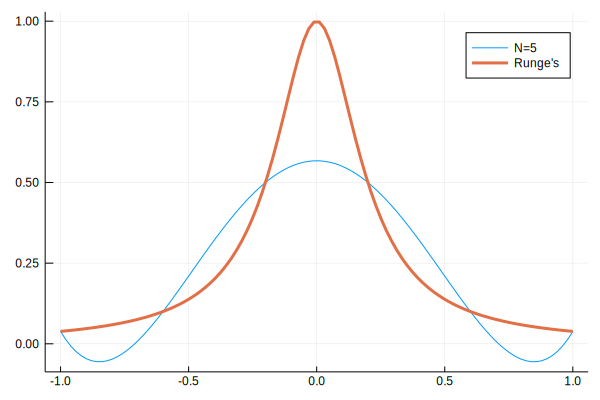

In [17]:
using Plots
N_display = 100
g(x) = 1/(1 + 25x^2)
x_display = range(-1, 1, length = N_display)
y_display = g.(x_display)

# interpolation
N = 5
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_5 = [x_i^n for x_i in x, n in 0:N]
c_5 = A_5 \ y

# use the coefficients to evaluate on x_display grid
B_5 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_5 = B_5 * c_5  # calculates for each in x_display_grid
plot(x_display, y_5, label = "N=5")
plot!(x_display, y_display, w = 3, label = "Runge's")

This has the hallmark oscillations near the boundaries of Runge’s Phenomena.  You might guess that increasing the number
of grid points and order of the polynomial will lead to better approximations

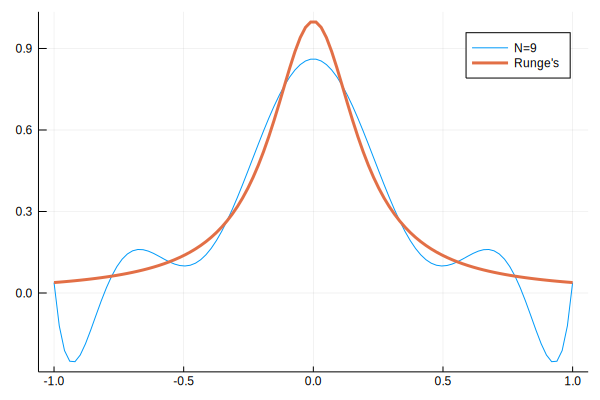

In [18]:
N = 9
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_9 = [x_i^n for x_i in x, n in 0:N]
c_9 = A_9 \ y

# use the coefficients to evaluate on x_display grid
B_9 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_9 = B_9 * c_9  # calculates for each in x_display_grid
plot(x_display, y_9, label = "N=9")
plot!(x_display, y_display, w = 3, label = "Runge's")

Instead, we see that while the approximation is better near `x=0`, the oscillations near the boundaries have become worse.

### Using an Orthogonal Polynomial Basis

We can minimize the numerical issues of an ill-conditioned matrix by choosing a different basis for the polynomials.

For example, with [Chebyshev polymomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials), which form an orthonormal basis, we can form precise high-order approximations, with very little numerical error

In [19]:
using ApproxFun
N = 10000
S = Chebyshev(0.0..10.0)  # form chebyshev basis
x = points(S, N)  # chooses better grid points, but that could be modified
y = f.(x)
f_approx = Fun(S,ApproxFun.transform(S,y))  # transform fits the polynomial
norm(f_approx.(x) - exp.(x), Inf)

3.637978807091713e-11

Besides the use of a different polynomial basis, we are approximating at different nodes (i.e. [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes)).  Interpolation with Chebyshev polynomials at the Chebyshev nodes ends up minimizing (but not eliminating) Runge’s Phenomena.

To summarize the analysis,

1. Check the condition number on systems you suspect might be ill-conditioned (based on intuition of collinearity).  
1. If you are working with ill-conditioned matrices, be especially careful not to take inverse.  
1. Avoid a monomial polynomial basis.  Instead, orthogonal polynomials (e.g. Chebyshev or Lagrange) which are orthogonal under the inner product, or non-global basis such as cubic-splines.  
1. If possible, avoid using a uniform grid for interpolation and approximation and choose nodes appropriate for the basis.  


However, sometimes you can’t avoid ill-conditioned matrices. This is especially common with discretization of PDEs and with linear-least squares.